In [140]:
import json
import requests
import http

class ABStreet():
    '''
    ABStreet simulation wrapper. Initialized on a per-map basis, can be reused for
    changes to map edits. Edits can be provided upon construction 
    '''
    def __init__(self, api, map_args=None, mods=None, edits=None, verbose=False):
        if map_args is None:
            map_args = {
                'country_code': 'us',
                'city_name':    'seattle',
                'map_name':     'montlake',
            }

        self.api = api
        self.map_args = map_args
        self.verbose = verbose
        self.modifiers = mods if mods else []
        self.core_edits = edits
        self.edits = edits

        self.scenario = 'data/system/{}/{}/scenarios/{}/weekday.bin'.format(
            map_args['country_code'],
            map_args['city_name'],
            map_args['map_name'],
        )

        self.load()

    def reset(self, flush_edits=True):
        '''
        Note: edits explicitly loaded during scenario config will be reapplied by the AB
        street after reset i.e. will be reset to initial state as seen in constructor.
        '''
        if flush_edits:
            self.edits = self.core_edits

        requests.get(self.api + '/sim/reset')
        self.load()

    def load(self):
        # load sim configuration
        requests.post(self.api + '/sim/load', json={
            'scenario':  self.scenario,
            'modifiers': self.modifiers,
            'edits':     self.edits,
        })

    def run(self, hours):
        '''
        Runs the configured scenario, using current edits. Both live and retroactive edits
        made during prior runs will be applied.

        Note: even if a simulation has not started, edits to road or intersection geometry
        require a scenario reload. Live edits (like traffic signal changes) are fine to
        apply and run without a reset. Either way, reset is called and all changes are
        carried over to take effect following the call to run().

        Note: still need to implement persisting live edits and merging with static edits.
        Could always reset and set edits to current edits + explicitly saved edits
        '''
        # reset with current edits
        #self.reset(flush_edits=False)

        requests.post(self.api + '/sim/goto-time', params={
            't': '{}:00:00'.format(hours)
        })

    def data(self):
        finished_trips = requests.get(self.api + '/data/get-finished-trips').json()
        road_thruput   = requests.get(self.api + '/data/get-road-thruput').json()

        trips = {}
        for trip in finished_trips:
            if trip['duration'] is not None and trip.get('id'):
                trips[trip['id']] = trip['duration']

        # get total thruput by agent type
        thruput = {}
        for road in road_thruput['counts']:
            if road[1] not in thruput: thruput[road[1]] = 0
            thruput[road[1]] += road[3]

        return {
            'num_completed_trips': len(trips),
            'avg_trip_duration': sum([d for d in trips.values()])/len(trips),
            'thruput_by_agent': thruput,
        }

    def get_map_edits(self):
        '''
        Returns current map edits. Useful for getting proper edits in change
        signal timing, which are necessarily applied live. Road and
        intersection edits must be added retroactively during a reset.
        '''
        return requests.get(self.api + '/map/get-edits').json()

    def get_traffic_signal_stages(self, sid):
        return requests.get(self.api + '/traffic-signals/get', params={'id': sid}).json()

    def set_traffic_signal_stages(self, sid, stage_timing):
        '''
        Traffic signals can have two stage types: fixed or variable. 

        - Fixed stage: `timing` is single numerical value (seconds), stage always lasts that
          fixed amount of time
        - Variable stage: `timing` is a list with 3 numerical values

        Takes a dictionary indexed by stage ID. Values for each ID are dictionaries with
        'stage_type' and 'timing' keys. For example, given an intersection with 4 stages,
        the input
        
        stage_timing = {
            '1': { 'Fixed': 30000 },
            '3': { 'Variable': [10000, 2000, 8000] },
        }

        will change the 2nd and 4th stages to fixed (30s) wait time and variable (with 10s min
        wait, 2s protected turn check wait for +8s max), respectively.
        '''
        ts = self.get_traffic_signal_stages(sid)

        for stage, settings in stage_timing.items():
            ts['stages'][stage]['stage_type'] = settings

        # apply live
        try:
            r = requests.post(self.api + '/traffic-signals/set', json=ts)
            return r.status_code
        except requests.exceptions.ConnectionError:
            print('Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server')
            return -1

    def save_edits(self, out):
        with open(out, 'w') as f:
            json.dump(self.get_map_edits(), f)

In [243]:
# visualization packages
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
import glob
from PIL import Image
import subprocess

from math import cos, pi, sin, sqrt
import numpy as np

import torch
import torch.nn as nn 
import torch.nn.functional as F

import sbi.utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

import time

API = 'http://localhost:1234'
ABSTREET_PATH = '/home/smgr/Documents/projects/_external/abstreet'
AB_CMD = 'cargo run --release --bin headless -- --port=1234'.split()

#abserver = {'proc': None}

def restart_abserver():
    print('Restarting AB server')
    if abserver['proc'] is not None:
        abserver['proc'].kill()
    abserver['proc'] = subprocess.Popen(ab_cmd, cwd=ABSTREET_PATH, stdout=subprocess.DEVNULL)
    time.sleep(3)

def plotting(posterior_samples):
    # mode posterior params
    mean = torch.mean(posterior_samples,axis=0).numpy()

    # mode posterior params
    mode = []
    for i in range(posterior_samples.shape[1]):
        n, bins = np.histogram(posterior_samples[:,i], bins=100)
        mode.append(bins[np.argmax(n)])

    # plot posterior samples
    _ = utils.pairplot(posterior_samples, fig_size=(5,5))
    plt.savefig('pairplot.png', format='png', dpi=300)

    # more detailed joint plot with mean, mode, and original parameter values
    a = sns.jointplot(
        x=posterior_samples[:,0].numpy().flatten(),
        y=posterior_samples[:,1].numpy().flatten(),
        #xlim=[0,length],
        #ylim=[0,width],
        marginal_ticks=False,
        kind="kde",
        marginal_kws=dict(fill=True))
    a.ax_joint.plot(mode[0], mode[1], 'go')
    a.ax_joint.text(mode[0]+2, mode[1]+0.5, 'mode')
    a.ax_joint.plot(mean[0], mean[1], 'yo')
    a.ax_joint.text(mean[0]+2, mean[1]+0.5, 'mean')
    #a.ax_joint.plot(rpos[0], rpos[1], 'rx')
    #a.ax_joint.text(rpos[0]+2, rpos[1]+0.5, 'target')
    plt.gcf().set_size_inches(10, 5.5)
    plt.savefig('density.png', format='png', dpi=300)

def sim_variable(params):
    '''
    Basic intersection sim, parametrized for signals at traffic light
    373@montlake. Params is a 12-dim vector with real values in accordance with
    variable traffic signal timing for each of four stages. Recovers fixed signal
    timing.
    '''
    rp = params.reshape([4,3])
    absim.reset()
    res = absim.set_traffic_signal_stages(373, {
        i : { 'Variable': (p*10000).tolist() } for i,p in enumerate(rp)
    })

    if res < 0:
        restart_abserver()
        return 10e8

    absim.run(24)
    return ab.data()['avg_trip_duration']

def sim_fixed(params):
    rp = params.reshape([4,1])
    absim.reset()
    res = absim.set_traffic_signal_stages(373, {
        i : { 'Fixed': int((p*10000).tolist()[0]) } for i,p in enumerate(rp)
    })

    if res < 0:
        restart_abserver()
        return torch.tensor([10e8])

    absim.run(24)
    return torch.tensor([absim.data()['avg_trip_duration']])

def sim_simple(params):
    absim.reset()
    res = absim.set_traffic_signal_stages(373, {
        i : { 'Fixed': int(params.tolist()[0]*10000) } for i in range(4)
    })

    if res < 0:
        restart_abserver()
        return torch.tensor([10e8])

    absim.run(24)
    return torch.tensor([absim.data()['avg_trip_duration']])


def sim_simple_var(params):
    absim.reset()
    stages = {
        i : { 'Variable': list(map(int, (params*10000).tolist())) } for i in range(4)
    }
    print('Submitting stages: {}'.format(stages))
    
    res = absim.set_traffic_signal_stages(373, stages)
    
    if res < 0:
        restart_abserver()
        return torch.tensor([10e5])

    absim.run(24)
    return torch.tensor([absim.data()['avg_trip_duration']])/10000

In [319]:
#abserver.kill()
restart_abserver()

Restarting AB server


    Finished release [optimized] target(s) in 0.11s
     Running `target/release/headless --port=1234`
[2021-12-14T07:39:36Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T07:39:36Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T07:39:36Z INFO  abstutil::time]   - ... plus 0.0041s
[2021-12-14T07:39:37Z INFO  abstutil::time] - setup headless took 0.1122s
[2021-12-14T07:39:37Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0154s
[2021-12-14T07:39:37Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0333s
[2021-12-14T07:39:37Z INFO  abstutil::time]   - generate movements (515)... 0.0013s
[2021-12-14T07:39:37Z INFO  abstutil::time]   - Instantiating weekday took 0.0567s
[2021-12-14T07:39:37Z INFO  abstutil::time]     - trips for People (13,570)... 0.0053s
[2021-12-14T07:39:37Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0099s
[2021-12-14T07:39:37

In [176]:
absim = ABStreet(API)

# get baseline
print('-- Running baseline --')
absim.run(18)
pre_duration = absim.data()['avg_trip_duration']

# establish prior over timing variables
print('-- Verifying SBI setup --')
#prior = utils.BoxUniform(low=torch.tensor([10]*4), high=torch.tensor([70]*4))
prior = utils.BoxUniform(low=torch.tensor([10]), high=torch.tensor([70]))

simulator, prior = prepare_for_sbi(sim_simple, prior)
inference = SNPE(prior)

[2021-12-14T03:19:29Z INFO  headless] Handling /sim/load
[2021-12-14T03:19:29Z INFO  abstutil::time] - create blank sim took 0.0033s
[2021-12-14T03:19:29Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0004s
[2021-12-14T03:19:29Z INFO  abstutil::time]   - ... plus 0.0030s
[2021-12-14T03:19:29Z INFO  abstutil::time] - reset sim took 0.1012s
[2021-12-14T03:19:29Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0183s
[2021-12-14T03:19:29Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0312s
[2021-12-14T03:19:29Z INFO  abstutil::time]   - generate movements (515)... 0.0007s
[2021-12-14T03:19:29Z INFO  abstutil::time]   - Instantiating weekday took 0.0462s
[2021-12-14T03:19:29Z INFO  abstutil::time]     - trips for People (13,570)... 0.0036s
[2021-12-14T03:19:29Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0095s
[2021-12-14T03:19:29Z INFO  abstutil::time]     - spawn trips (36,796).

-- Running baseline --


[2021-12-14T03:19:37Z INFO  abstutil::time] - goto-time took 7.4207s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - Advance sim to 18:00:00.0 took 7.4207s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - ... plus 0.0000s
[2021-12-14T03:19:37Z INFO  headless] Handling /data/get-finished-trips
[2021-12-14T03:19:37Z INFO  headless] Handling /data/get-road-thruput
[2021-12-14T03:19:37Z INFO  headless] Handling /sim/reset
[2021-12-14T03:19:37Z INFO  abstutil::time] - create blank sim took 0.0033s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - ... plus 0.0029s
[2021-12-14T03:19:37Z INFO  abstutil::time] - reset sim took 0.0953s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0145s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0312s
[2021-12-14T03:19:37Z INFO  abstutil::time]   -

-- Verifying SBI setup --


[2021-12-14T03:19:37Z INFO  abstutil::time] - create blank sim took 0.0033s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - ... plus 0.0030s
[2021-12-14T03:19:37Z INFO  abstutil::time] - reset sim took 0.0874s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0148s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0308s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - generate movements (515)... 0.0008s
[2021-12-14T03:19:37Z INFO  abstutil::time]   - Instantiating weekday took 0.0365s
[2021-12-14T03:19:37Z INFO  abstutil::time]     - trips for People (13,570)... 0.0038s
[2021-12-14T03:19:37Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0092s
[2021-12-14T03:19:37Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0221s
[2021-12-14T03:19:37Z INFO  abstutil::time]   

In [177]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=250)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

Running 250 simulations.:   0%|          | 0/250 [00:00<?, ?it/s]

[2021-12-14T03:20:08Z INFO  headless] Handling /sim/reset
[2021-12-14T03:20:08Z INFO  abstutil::time] - create blank sim took 0.0033s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0005s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - ... plus 0.0029s
[2021-12-14T03:20:08Z INFO  abstutil::time] - reset sim took 0.1049s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0162s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0312s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - generate movements (515)... 0.0007s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - Instantiating weekday took 0.0518s
[2021-12-14T03:20:08Z INFO  abstutil::time]     - trips for People (13,570)... 0.0038s
[2021-12-14T03:20:08Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0091s
[2021-12-14T03:20:08Z INFO  abstutil::time]     - spawn trips (36,796)

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:20:08Z INFO  abstutil::time] - setup headless took 0.1122s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0332s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - generate movements (515)... 0.0016s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - Instantiating weekday took 0.0569s
[2021-12-14T03:20:08Z INFO  abstutil::time]     - trips for People (13,570)... 0.0053s
[2021-12-14T03:20:08Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0099s
[2021-12-14T03:20:08Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0400s
[2021-12-14T03:20:08Z INFO  abstutil::time]     - ... plus 0.0017s
[2021-12-14T03:20:08Z INFO  abstutil::time]   - ... plus 0.0053s
[2021-12-14T03:20:08Z INFO  abstutil::time] - create blank sim took 0.0003s
[2021-12-14T03:20:08Z INFO  headless] Listening on http://127.0.0

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:21:55Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T03:21:55Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:21:55Z INFO  abstutil::time]   - ... plus 0.0040s
[2021-12-14T03:21:56Z INFO  abstutil::time] - setup headless took 0.1127s
[2021-12-14T03:21:56Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:21:56Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0338s
[2021-12-14T03:21:56Z INFO  abstutil::time]   - generate movements (515)... 0.0014s
[2021-12-14T03:21:56Z INFO  abstutil::time]   - Instantiating weekday took 0.0570s
[2021-12-14T03:21:56Z INFO  abstutil::time]     - trips for People (13,570)... 0.0054s
[2021-12-14T03:21:56Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0100s
[2021-12-14T03:21:56Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0400s
[2021-12-14T03:21:56Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:22:22Z INFO  abstutil::time] - create blank sim took 0.0056s
[2021-12-14T03:22:22Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0004s
[2021-12-14T03:22:22Z INFO  abstutil::time]   - ... plus 0.0052s
[2021-12-14T03:22:22Z INFO  abstutil::time] - setup headless took 0.1146s
[2021-12-14T03:22:22Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:22:22Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0339s
[2021-12-14T03:22:22Z INFO  abstutil::time]   - generate movements (515)... 0.0017s
[2021-12-14T03:22:22Z INFO  abstutil::time]   - Instantiating weekday took 0.0572s
[2021-12-14T03:22:22Z INFO  abstutil::time]     - trips for People (13,570)... 0.0052s
[2021-12-14T03:22:22Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0101s
[2021-12-14T03:22:22Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0402s
[2021-12-14T03:22:22Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:28:54Z INFO  abstutil::time] - create blank sim took 0.0043s
[2021-12-14T03:28:54Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:28:54Z INFO  abstutil::time]   - ... plus 0.0040s
[2021-12-14T03:28:54Z INFO  abstutil::time] - setup headless took 0.1121s
[2021-12-14T03:28:54Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:28:54Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0338s
[2021-12-14T03:28:54Z INFO  abstutil::time]   - generate movements (515)... 0.0012s
[2021-12-14T03:28:54Z INFO  abstutil::time]   - Instantiating weekday took 0.0566s
[2021-12-14T03:28:54Z INFO  abstutil::time]     - trips for People (13,570)... 0.0052s
[2021-12-14T03:28:54Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0098s
[2021-12-14T03:28:54Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0399s
[2021-12-14T03:28:54Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:29:29Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T03:29:29Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:29:29Z INFO  abstutil::time]   - ... plus 0.0040s
[2021-12-14T03:29:29Z INFO  abstutil::time] - setup headless took 0.1130s
[2021-12-14T03:29:29Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:29:29Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0338s
[2021-12-14T03:29:29Z INFO  abstutil::time]   - generate movements (515)... 0.0015s
[2021-12-14T03:29:29Z INFO  abstutil::time]   - Instantiating weekday took 0.0571s
[2021-12-14T03:29:29Z INFO  abstutil::time]     - trips for People (13,570)... 0.0052s
[2021-12-14T03:29:29Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0099s
[2021-12-14T03:29:29Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0403s
[2021-12-14T03:29:29Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:29:48Z INFO  abstutil::time] - create blank sim took 0.0043s
[2021-12-14T03:29:48Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:29:48Z INFO  abstutil::time]   - ... plus 0.0040s
[2021-12-14T03:29:48Z INFO  abstutil::time] - setup headless took 0.1120s
[2021-12-14T03:29:48Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:29:48Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0333s
[2021-12-14T03:29:48Z INFO  abstutil::time]   - generate movements (515)... 0.0014s
[2021-12-14T03:29:48Z INFO  abstutil::time]   - Instantiating weekday took 0.0568s
[2021-12-14T03:29:48Z INFO  abstutil::time]     - trips for People (13,570)... 0.0053s
[2021-12-14T03:29:48Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0099s
[2021-12-14T03:29:48Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0399s
[2021-12-14T03:29:48Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:30:55Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T03:30:55Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:30:55Z INFO  abstutil::time]   - ... plus 0.0040s
[2021-12-14T03:30:55Z INFO  abstutil::time] - setup headless took 0.1135s
[2021-12-14T03:30:55Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:30:55Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0338s
[2021-12-14T03:30:55Z INFO  abstutil::time]   - generate movements (515)... 0.0014s
[2021-12-14T03:30:55Z INFO  abstutil::time]   - Instantiating weekday took 0.0578s
[2021-12-14T03:30:55Z INFO  abstutil::time]     - trips for People (13,570)... 0.0053s
[2021-12-14T03:30:55Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0108s
[2021-12-14T03:30:55Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0401s
[2021-12-14T03:30:55Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:32:57Z INFO  abstutil::time] - create blank sim took 0.0043s
[2021-12-14T03:32:57Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:32:57Z INFO  abstutil::time]   - ... plus 0.0040s
[2021-12-14T03:32:57Z INFO  abstutil::time] - setup headless took 0.1127s
[2021-12-14T03:32:57Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:32:57Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0334s
[2021-12-14T03:32:57Z INFO  abstutil::time]   - generate movements (515)... 0.0014s
[2021-12-14T03:32:57Z INFO  abstutil::time]   - Instantiating weekday took 0.0573s
[2021-12-14T03:32:57Z INFO  abstutil::time]     - trips for People (13,570)... 0.0052s
[2021-12-14T03:32:57Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0100s
[2021-12-14T03:32:57Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0405s
[2021-12-14T03:32:57Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:46:00Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T03:46:00Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0004s
[2021-12-14T03:46:00Z INFO  abstutil::time]   - ... plus 0.0040s
[2021-12-14T03:46:00Z INFO  abstutil::time] - setup headless took 0.1135s
[2021-12-14T03:46:00Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:46:00Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0334s
[2021-12-14T03:46:00Z INFO  abstutil::time]   - generate movements (515)... 0.0021s
[2021-12-14T03:46:00Z INFO  abstutil::time]   - Instantiating weekday took 0.0573s
[2021-12-14T03:46:00Z INFO  abstutil::time]     - trips for People (13,570)... 0.0053s
[2021-12-14T03:46:00Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0100s
[2021-12-14T03:46:00Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0403s
[2021-12-14T03:46:00Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:48:26Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T03:48:26Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:48:26Z INFO  abstutil::time]   - ... plus 0.0041s
[2021-12-14T03:48:26Z INFO  abstutil::time] - setup headless took 0.1134s
[2021-12-14T03:48:26Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:48:26Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0338s
[2021-12-14T03:48:26Z INFO  abstutil::time]   - generate movements (515)... 0.0016s
[2021-12-14T03:48:26Z INFO  abstutil::time]   - Instantiating weekday took 0.0573s
[2021-12-14T03:48:26Z INFO  abstutil::time]     - trips for People (13,570)... 0.0054s
[2021-12-14T03:48:26Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0100s
[2021-12-14T03:48:26Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0402s
[2021-12-14T03:48:26Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:49:24Z INFO  abstutil::time] - create blank sim took 0.0054s
[2021-12-14T03:49:24Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0004s
[2021-12-14T03:49:24Z INFO  abstutil::time]   - ... plus 0.0051s
[2021-12-14T03:49:24Z INFO  abstutil::time] - setup headless took 0.1138s
[2021-12-14T03:49:24Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:49:24Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0334s
[2021-12-14T03:49:24Z INFO  abstutil::time]   - generate movements (515)... 0.0019s
[2021-12-14T03:49:24Z INFO  abstutil::time]   - Instantiating weekday took 0.0568s
[2021-12-14T03:49:24Z INFO  abstutil::time]     - trips for People (13,570)... 0.0052s
[2021-12-14T03:49:24Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0100s
[2021-12-14T03:49:24Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0400s
[2021-12-14T03:49:24Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


    Finished release [optimized] target(s) in 0.11s
     Running `target/release/headless --port=1234`
[2021-12-14T03:50:15Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T03:50:15Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:50:15Z INFO  abstutil::time]   - ... plus 0.0041s
[2021-12-14T03:50:15Z INFO  abstutil::time] - setup headless took 0.1126s
[2021-12-14T03:50:15Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:50:15Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0333s
[2021-12-14T03:50:15Z INFO  abstutil::time]   - generate movements (515)... 0.0020s
[2021-12-14T03:50:15Z INFO  abstutil::time]   - Instantiating weekday took 0.0566s
[2021-12-14T03:50:15Z INFO  abstutil::time]     - trips for People (13,570)... 0.0052s
[2021-12-14T03:50:15Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0098s
[2021-12-14T03:50:15

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:50:34Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T03:50:34Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:50:34Z INFO  abstutil::time]   - ... plus 0.0041s
[2021-12-14T03:50:34Z INFO  abstutil::time] - setup headless took 0.1122s
[2021-12-14T03:50:34Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:50:34Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0333s
[2021-12-14T03:50:34Z INFO  abstutil::time]   - generate movements (515)... 0.0014s
[2021-12-14T03:50:34Z INFO  abstutil::time]   - Instantiating weekday took 0.0569s
[2021-12-14T03:50:34Z INFO  abstutil::time]     - trips for People (13,570)... 0.0053s
[2021-12-14T03:50:34Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0099s
[2021-12-14T03:50:34Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0400s
[2021-12-14T03:50:34Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:50:37Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T03:50:37Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:50:37Z INFO  abstutil::time]   - ... plus 0.0041s
[2021-12-14T03:50:37Z INFO  abstutil::time] - setup headless took 0.1124s
[2021-12-14T03:50:37Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0152s
[2021-12-14T03:50:37Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0333s
[2021-12-14T03:50:37Z INFO  abstutil::time]   - generate movements (515)... 0.0014s
[2021-12-14T03:50:37Z INFO  abstutil::time]   - Instantiating weekday took 0.0571s
[2021-12-14T03:50:37Z INFO  abstutil::time]     - trips for People (13,570)... 0.0052s
[2021-12-14T03:50:37Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0098s
[2021-12-14T03:50:37Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0403s
[2021-12-14T03:50:37Z INFO  abstutil::tim

Invalid traffic signal setting (likely too little time for crosswalk. Restart the ABStreet server
Restarting AB server


[2021-12-14T03:51:59Z INFO  abstutil::time] - create blank sim took 0.0055s
[2021-12-14T03:51:59Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T03:51:59Z INFO  abstutil::time]   - ... plus 0.0052s
[2021-12-14T03:51:59Z INFO  abstutil::time] - setup headless took 0.1148s
[2021-12-14T03:51:59Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0153s
[2021-12-14T03:51:59Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0334s
[2021-12-14T03:51:59Z INFO  abstutil::time]   - generate movements (515)... 0.0020s
[2021-12-14T03:51:59Z INFO  abstutil::time]   - Instantiating weekday took 0.0575s
[2021-12-14T03:51:59Z INFO  abstutil::time]     - trips for People (13,570)... 0.0053s
[2021-12-14T03:51:59Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0100s
[2021-12-14T03:51:59Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0405s
[2021-12-14T03:51:59Z INFO  abstutil::tim

Neural network successfully converged after 35 epochs.


In [194]:
posterior_samples = posterior.sample((50000,), x=torch.tensor([pre_duration-70000]))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(


IndexError: index 1 is out of bounds for dimension 1 with size 1

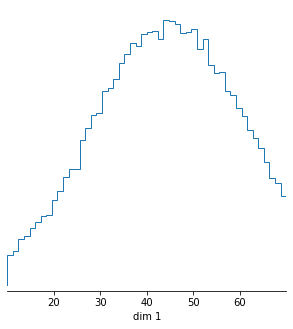

In [198]:
posterior_samples = posterior.sample((50000,), x=torch.tensor([pre_duration+10000]))
plotting(posterior_samples)

In [200]:
means = []
for i in range(-10,10):
    posterior_samples = posterior.sample((50000,), x=torch.tensor([pre_duration+i*10000]))
    means.append(torch.mean(posterior_samples,axis=0).numpy())

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

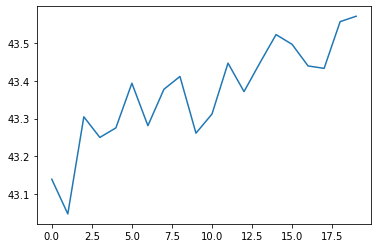

In [202]:
plt.plot(means)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(


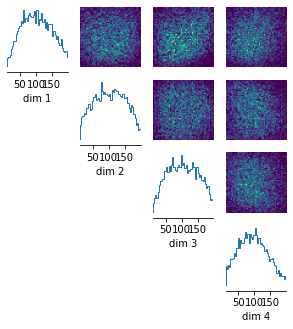

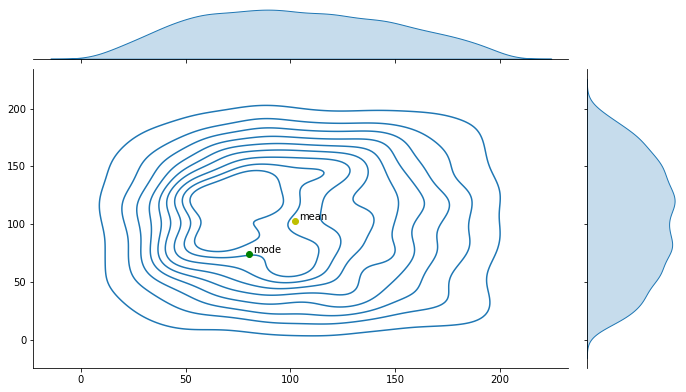

In [153]:
posterior_samples = posterior.sample((5000,), x=torch.tensor([pre_duration-100000]))
plotting(posterior_samples)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(


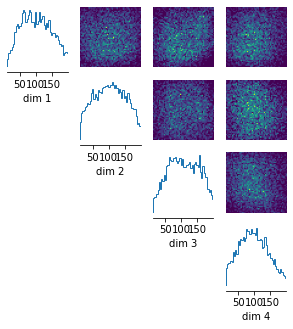

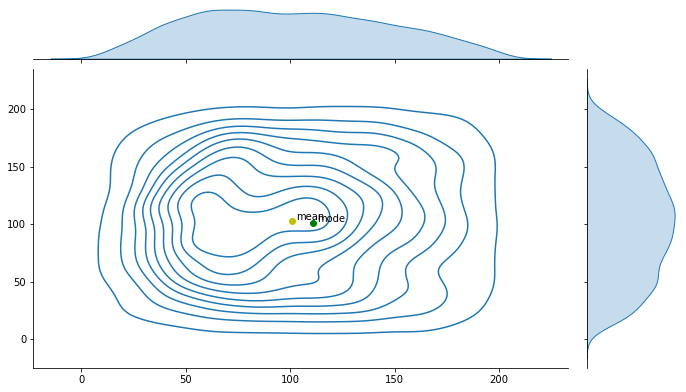

In [166]:
posterior_samples = posterior.sample((5000,), x=torch.tensor([pre_duration+300000]))
plotting(posterior_samples)

In [190]:
np.argmin(x)

tensor(129)

In [191]:
x[129]

tensor([5371911.5000])

In [192]:
theta[129]

tensor([13.0513])

In [203]:
theta[

tensor([[12.3596],
        [52.0510],
        [51.4472],
        [64.0139],
        [15.1873],
        [17.3962],
        [58.5126],
        [24.4599],
        [56.2989],
        [38.3976],
        [69.4137],
        [15.2518],
        [34.9387],
        [33.2848],
        [10.8017],
        [30.0946],
        [15.6414],
        [25.2180],
        [12.0344],
        [64.7485],
        [61.9342],
        [66.4083],
        [43.7232],
        [60.5581],
        [20.1427],
        [16.5818],
        [69.4513],
        [65.2185],
        [38.2029],
        [47.5321],
        [21.9862],
        [59.4295],
        [61.3449],
        [59.7221],
        [15.9279],
        [30.2171],
        [64.5900],
        [25.8727],
        [40.3080],
        [48.4896],
        [49.1979],
        [58.2457],
        [33.0061],
        [18.8234],
        [16.1869],
        [31.6039],
        [68.5443],
        [38.8559],
        [33.2897],
        [18.3861],
        [49.7135],
        [27.1400],
        [24.

In [205]:
print(x[4])
print(x[1])

tensor([5372617.])
tensor([5564377.5000])


In [171]:
x_b = x
theta_b = theta

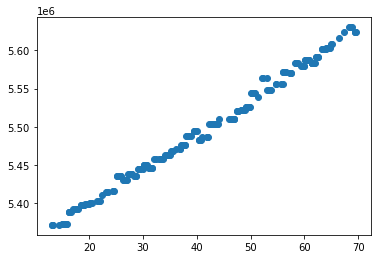

In [207]:
plt.scatter(theta[x<1e8], x[x<1e8])

In [214]:
x_s = x
theta_s = theta

In [287]:
absim = ABStreet(API)

# get baseline
print('-- Running baseline --')
absim.run(24)
pre_duration = absim.data()['avg_trip_duration']/10000

# establish prior over timing variables
print('-- Verifying SBI setup --')
#prior = utils.BoxUniform(low=torch.tensor([10]*4), high=torch.tensor([70]*4))
prior = utils.BoxUniform(low=torch.tensor([12,0,0]), high=torch.tensor([80,20,80]))

simulator, prior = prepare_for_sbi(sim_simple_var, prior)
inference = SNPE(prior)

[2021-12-14T07:24:28Z INFO  headless] Handling /sim/load
[2021-12-14T07:24:28Z INFO  abstutil::time] - create blank sim took 0.0032s
[2021-12-14T07:24:28Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0002s
[2021-12-14T07:24:28Z INFO  abstutil::time]   - ... plus 0.0030s
[2021-12-14T07:24:28Z INFO  abstutil::time] - reset sim took 0.0806s
[2021-12-14T07:24:28Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0154s
[2021-12-14T07:24:28Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0317s
[2021-12-14T07:24:28Z INFO  abstutil::time]   - generate movements (515)... 0.0008s
[2021-12-14T07:24:28Z INFO  abstutil::time]   - Instantiating weekday took 0.0285s
[2021-12-14T07:24:28Z INFO  abstutil::time]     - trips for People (13,570)... 0.0038s
[2021-12-14T07:24:28Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0092s
[2021-12-14T07:24:28Z INFO  abstutil::time]     - spawn trips (36,796).

-- Running baseline --


[2021-12-14T07:24:37Z INFO  abstutil::time] - goto-time took 9.5255s
[2021-12-14T07:24:37Z INFO  abstutil::time]   - Advance sim to 24:00:00.0 took 9.5255s
[2021-12-14T07:24:37Z INFO  abstutil::time]   - ... plus 0.0000s
[2021-12-14T07:24:37Z INFO  headless] Handling /data/get-finished-trips
[2021-12-14T07:24:37Z INFO  headless] Handling /data/get-road-thruput
[2021-12-14T07:24:38Z INFO  headless] Handling /sim/reset


-- Verifying SBI setup --


[2021-12-14T07:24:38Z INFO  abstutil::time] - create blank sim took 0.0033s
[2021-12-14T07:24:38Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T07:24:38Z INFO  abstutil::time]   - ... plus 0.0030s
[2021-12-14T07:24:38Z INFO  abstutil::time] - reset sim took 0.0925s
[2021-12-14T07:24:38Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0145s
[2021-12-14T07:24:38Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0313s
[2021-12-14T07:24:38Z INFO  abstutil::time]   - generate movements (515)... 0.0010s
[2021-12-14T07:24:38Z INFO  abstutil::time]   - Instantiating weekday took 0.0411s
[2021-12-14T07:24:38Z INFO  abstutil::time]     - trips for People (13,570)... 0.0039s
[2021-12-14T07:24:38Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0092s
[2021-12-14T07:24:38Z INFO  abstutil::time]     - spawn trips (36,796)... 0.0266s
[2021-12-14T07:24:38Z INFO  abstutil::time]   

Submitting stages: {0: {'Variable': [157384, 128304, 471382]}, 1: {'Variable': [157384, 128304, 471382]}, 2: {'Variable': [157384, 128304, 471382]}, 3: {'Variable': [157384, 128304, 471382]}}


[2021-12-14T07:24:48Z INFO  abstutil::time] - goto-time took 9.6654s
[2021-12-14T07:24:48Z INFO  abstutil::time]   - Advance sim to 24:00:00.0 took 9.6654s
[2021-12-14T07:24:48Z INFO  abstutil::time]   - ... plus 0.0000s
[2021-12-14T07:24:48Z INFO  headless] Handling /data/get-finished-trips
[2021-12-14T07:24:48Z INFO  headless] Handling /data/get-road-thruput


In [295]:
#theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=500)
density_estimator = inference.append_simulations(theta[x.flatten()<1e5], x[x.flatten()<1e5]).train()
posterior = inference.build_posterior(density_estimator)

Neural network successfully converged after 107 epochs.


Drawing 30000 posterior samples:   0%|          | 0/30000 [00:00<?, ?it/s]

/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(


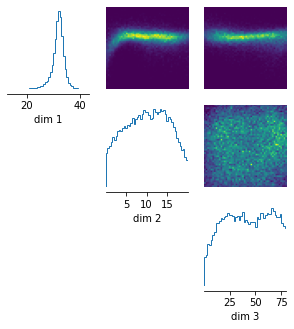

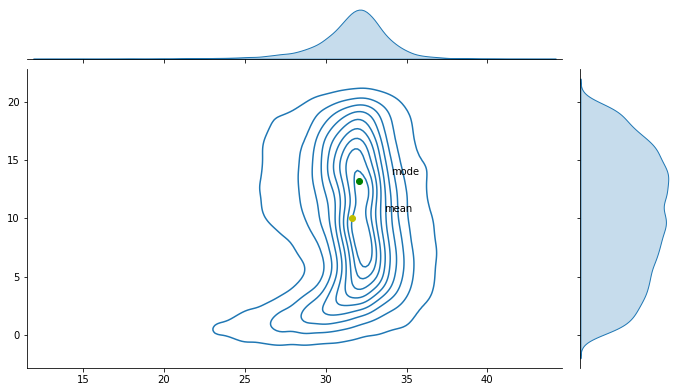

In [301]:
posterior_samples = posterior.sample((30000,), x=torch.tensor([pre_duration]))
plotting(posterior_samples)

Drawing 30000 posterior samples:   0%|          | 0/30000 [00:00<?, ?it/s]

/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(


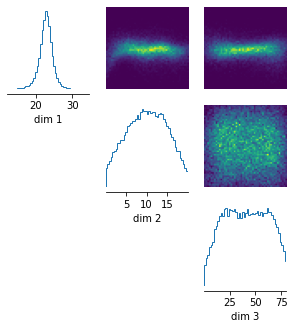

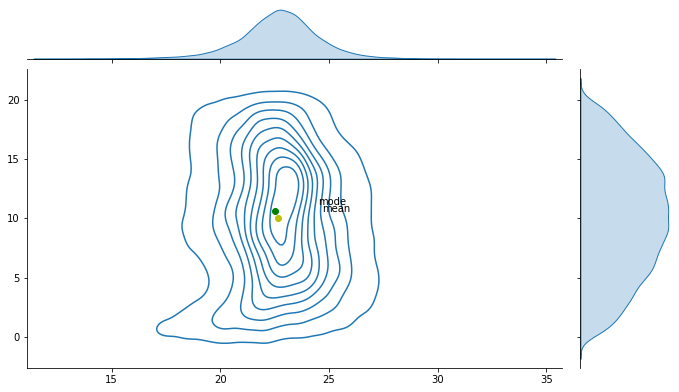

In [302]:
posterior_samples = posterior.sample((30000,), x=torch.tensor([pre_duration-4]))
plotting(posterior_samples)

Drawing 30000 posterior samples:   0%|          | 0/30000 [00:00<?, ?it/s]

/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(


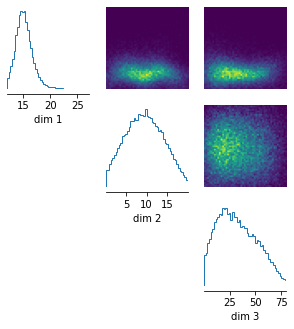

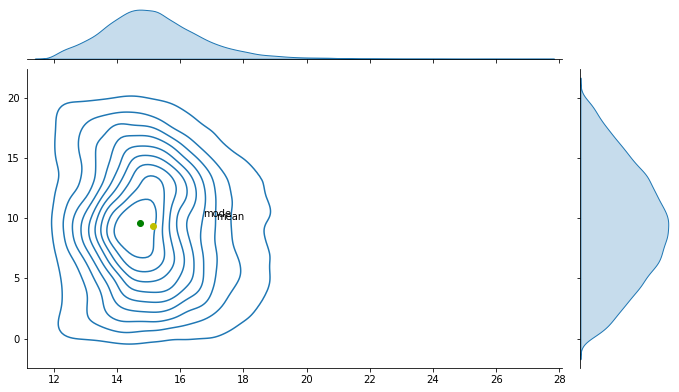

In [303]:
posterior_samples = posterior.sample((30000,), x=torch.tensor([pre_duration-8]))
plotting(posterior_samples)

Drawing 30000 posterior samples:   0%|          | 0/30000 [00:00<?, ?it/s]

/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:188: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  warn(
/home/smgr/.local/lib/python3.9/site-packages/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(


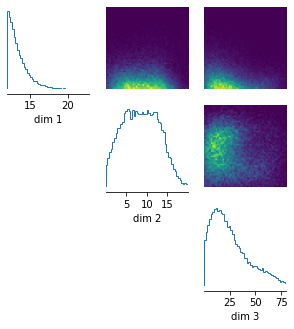

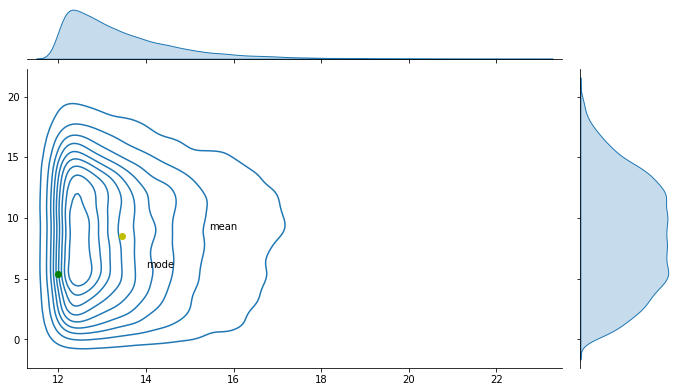

In [331]:
posterior_samples = posterior.sample((30000,), x=torch.tensor([pre_duration-10]))
plotting(posterior_samples)

In [283]:
np.argmin(x)

tensor(64)

In [286]:
theta[np.argmin(x)]

tensor([13.9506, 12.8734, 37.9257])

In [307]:
print(pre_duration)
print(pre_duration-x[np.argmin(x)])

551.9855758490772
tensor([8.3578])


In [323]:
x[np.argmin(x)]

tensor([543.6277])

In [308]:
pre_duration-x_s[np.argmin(x_s)]/10000

tensor([14.7944])

In [309]:
pre_duration-x_b[np.argmin(x_b)]/10000

tensor([-6.8008])

In [310]:
theta_s[np.argmin(x_s)]

tensor([13.0513])

In [332]:
mode = []
for i in range(posterior_samples.shape[1]):
    n, bins = np.histogram(posterior_samples[:,i], bins=100)
    mode.append(bins[np.argmax(n)])

In [333]:
mode

[12.000078, 5.3879476, 12.000873]

In [328]:
# \theta|pre_dur-12
print(sim_simple_var(torch.tensor([13.00106, 9.588944, 3.196123])))

[2021-12-14T07:41:43Z INFO  headless] Handling /sim/reset
[2021-12-14T07:41:44Z INFO  abstutil::time] - create blank sim took 0.0044s
[2021-12-14T07:41:44Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T07:41:44Z INFO  abstutil::time]   - ... plus 0.0041s
[2021-12-14T07:41:44Z INFO  abstutil::time] - reset sim took 0.1078s
[2021-12-14T07:41:44Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0164s
[2021-12-14T07:41:44Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0341s
[2021-12-14T07:41:44Z INFO  abstutil::time]   - generate movements (515)... 0.0014s
[2021-12-14T07:41:44Z INFO  abstutil::time]   - Instantiating weekday took 0.0503s
[2021-12-14T07:41:44Z INFO  abstutil::time]     - trips for People (13,570)... 0.0079s
[2021-12-14T07:41:44Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0093s
[2021-12-14T07:41:44Z INFO  abstutil::time]     - spawn trips (36,796)

Submitting stages: {0: {'Variable': [130010, 95889, 31961]}, 1: {'Variable': [130010, 95889, 31961]}, 2: {'Variable': [130010, 95889, 31961]}, 3: {'Variable': [130010, 95889, 31961]}}
tensor([543.7535])


[2021-12-14T07:41:53Z INFO  abstutil::time] - goto-time took 9.4121s
[2021-12-14T07:41:53Z INFO  abstutil::time]   - Advance sim to 24:00:00.0 took 9.4120s
[2021-12-14T07:41:53Z INFO  abstutil::time]   - ... plus 0.0000s
[2021-12-14T07:41:53Z INFO  headless] Handling /data/get-finished-trips
[2021-12-14T07:41:53Z INFO  headless] Handling /data/get-road-thruput


In [330]:
# \theta|pre_dur-14
print(sim_simple_var(torch.tensor([13.000007, 9.198499, 0.00066082])))

[2021-12-14T07:42:10Z INFO  headless] Handling /sim/reset
[2021-12-14T07:42:10Z INFO  abstutil::time] - create blank sim took 0.0047s
[2021-12-14T07:42:10Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T07:42:10Z INFO  abstutil::time]   - ... plus 0.0044s
[2021-12-14T07:42:10Z INFO  abstutil::time] - reset sim took 0.1309s
[2021-12-14T07:42:10Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0157s
[2021-12-14T07:42:10Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0339s
[2021-12-14T07:42:10Z INFO  abstutil::time]   - generate movements (515)... 0.0026s
[2021-12-14T07:42:10Z INFO  abstutil::time]   - Instantiating weekday took 0.0728s
[2021-12-14T07:42:10Z INFO  abstutil::time]     - trips for People (13,570)... 0.0092s
[2021-12-14T07:42:10Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0158s
[2021-12-14T07:42:10Z INFO  abstutil::time]     - spawn trips (36,796)

Submitting stages: {0: {'Variable': [130000, 91984, 6]}, 1: {'Variable': [130000, 91984, 6]}, 2: {'Variable': [130000, 91984, 6]}, 3: {'Variable': [130000, 91984, 6]}}
tensor([544.3745])


[2021-12-14T07:42:20Z INFO  abstutil::time] - goto-time took 9.5910s
[2021-12-14T07:42:20Z INFO  abstutil::time]   - Advance sim to 24:00:00.0 took 9.5910s
[2021-12-14T07:42:20Z INFO  abstutil::time]   - ... plus 0.0000s
[2021-12-14T07:42:20Z INFO  headless] Handling /data/get-finished-trips
[2021-12-14T07:42:20Z INFO  headless] Handling /data/get-road-thruput


In [335]:
# \theta|pre_dur-10
print(sim_simple_var(torch.tensor([13.000078, 5.3879476, 12.000873])))

[2021-12-14T07:44:15Z INFO  headless] Handling /sim/reset
[2021-12-14T07:44:15Z INFO  abstutil::time] - create blank sim took 0.0051s
[2021-12-14T07:44:15Z INFO  abstutil::time]   - setup offstreet parking (3,100)... 0.0003s
[2021-12-14T07:44:15Z INFO  abstutil::time]   - ... plus 0.0048s
[2021-12-14T07:44:15Z INFO  abstutil::time] - reset sim took 0.1223s
[2021-12-14T07:44:15Z INFO  abstutil::time]   - Read data/system/us/seattle/scenarios/montlake/weekday.bin (1)... 0.0168s
[2021-12-14T07:44:15Z INFO  abstutil::time]   - Read data/system/us/seattle/maps/montlake.bin (3)... 0.0339s
[2021-12-14T07:44:15Z INFO  abstutil::time]   - generate movements (515)... 0.0031s
[2021-12-14T07:44:15Z INFO  abstutil::time]   - Instantiating weekday took 0.0623s
[2021-12-14T07:44:15Z INFO  abstutil::time]     - trips for People (13,570)... 0.0117s
[2021-12-14T07:44:15Z INFO  abstutil::time]     - seed parked cars (5,072)... 0.0159s
[2021-12-14T07:44:15Z INFO  abstutil::time]     - spawn trips (36,796)

Submitting stages: {0: {'Variable': [130000, 53879, 120008]}, 1: {'Variable': [130000, 53879, 120008]}, 2: {'Variable': [130000, 53879, 120008]}, 3: {'Variable': [130000, 53879, 120008]}}
tensor([544.1312])


[2021-12-14T07:44:25Z INFO  abstutil::time] - goto-time took 9.5183s
[2021-12-14T07:44:25Z INFO  abstutil::time]   - Advance sim to 24:00:00.0 took 9.5183s
[2021-12-14T07:44:25Z INFO  abstutil::time]   - ... plus 0.0000s
[2021-12-14T07:44:25Z INFO  headless] Handling /data/get-finished-trips
[2021-12-14T07:44:25Z INFO  headless] Handling /data/get-road-thruput


In [340]:
import pickle

with open('saved.pkl','wb') as f:
    pickle.dump({
        'x_fixed': x_b,
        'theta_fixed': theta_b,
        'x_simple': x_s,
        'theta_simple': theta_s,
        'x_simple_var': x,
        'theta_simple_var': theta,
    }, f)